*   Nama  : Mohamad Farrel Aryansyah
*   ID    : MC009D5Y2453
*   Kelas : MC-27

# Analisis Sentimen Review Aplikasi Blu by BCA di Play Store

## Import Library

In [1]:
!pip install Sastrawi
!pip install gensim

In [2]:
#!pip install --upgrade --force-reinstall gensim

In [3]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import gensim
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback

In [4]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Load Data

In [5]:
df = pd.read_csv('Blu_review.csv')
df

,userName,score,content
0,Heri GamerZ卐,5,sudah cukup untuk kebutuhan nabung dan transak...
1,Ramadhani Wisnu Habibullah,5,apk nya di buat ringan aja dong kaya mbanking ...
2,Eva simangunsong,5,"kok bku BCA ku , minta masukin no handphone da..."
3,Misnawati Dewi,5,keren
4,Anan Rusmana,5,blu digital bca mantaap lach
...,...,...,...
9995,Únan Ryandrá (Braga` Nagaa),5,"ini apps keren banget sih, gak bakal ke ganggu..."
9996,Alastor Alastor,5,HP saya ilang semalam mau login ke apk blu by ...
9997,Danivivi Vita19,5,"aplikasi nya bagus,tapi tolong di benar kan la..."
9998,Gulali Jawa,1,Gimana ini setelah update aplikasinya ga bisa ...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  10000 non-null  object
 1   score     10000 non-null  int64 
 2   content   10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


## Melakukan tahapan ekstraksi fitur dan pelabelan data

### Preprocessing Data & Tokenisasi

In [7]:
# Fungsi untuk membersihkan teks dari karakter tidak penting
def clean_text(text):
    text = text.lower()                                # Ubah teks ke huruf kecil
    text = re.sub(r'http\S+', '', text)                # Hapus URL
    text = re.sub(r'@\S+', '', text)                   # Hapus mention
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)         # Hapus karakter selain huruf dan angka
    return text

# Menghapus stop words dan melakukan stemming
stop_words = set(stopwords.words('indonesian'))
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi preprocessing: pembersihan teks + tokenisasi + stopword removal + stemming
def preprocess(text):
    if pd.isnull(text):
        return ''
    text = clean_text(text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    return ' '.join(stemmed_tokens)

# Terapkan preprocessing ke kolom 'content'
df['cleaned_content'] = df['content'].apply(preprocess)

# Tampilkan contoh hasil pembersihan
print(df[['content', 'cleaned_content']].head())

                                             content  \
0  sudah cukup untuk kebutuhan nabung dan transak...   
1  apk nya di buat ringan aja dong kaya mbanking ...   
2  kok bku BCA ku , minta masukin no handphone da...   
3                                              keren   
4                       blu digital bca mantaap lach   

                                     cleaned_content  
0  butuh nabung transaksi seharihari kartu debit ...  
1  apk nya ringan aja kaya mbanking nya bca biar ...  
2  bku bca ku masukin no handphone dah masukin no...  
3                                              keren  
4                       blu digital bca mantaap lach  


### Label Data, Encoding

In [8]:
# Fungsi untuk melabeli data berdasarkan skor
def label_sentiment(score):
    if score >= 4:
        return 'positif'
    elif score <= 2:
        return 'negatif'
    else:
        return 'netral'

df['label'] = df['score'].apply(label_sentiment)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print(df['label'].value_counts())
df.head()

label
positif    6100
negatif    2800
netral     1100
Name: count, dtype: int64


,userName,score,content,cleaned_content,label,label_encoded
0,Heri GamerZ卐,5,sudah cukup untuk kebutuhan nabung dan transak...,butuh nabung transaksi seharihari kartu debit ...,positif,2
1,Ramadhani Wisnu Habibullah,5,apk nya di buat ringan aja dong kaya mbanking ...,apk nya ringan aja kaya mbanking nya bca biar ...,positif,2
2,Eva simangunsong,5,"kok bku BCA ku , minta masukin no handphone da...",bku bca ku masukin no handphone dah masukin no...,positif,2
3,Misnawati Dewi,5,keren,keren,positif,2
4,Anan Rusmana,5,blu digital bca mantaap lach,blu digital bca mantaap lach,positif,2


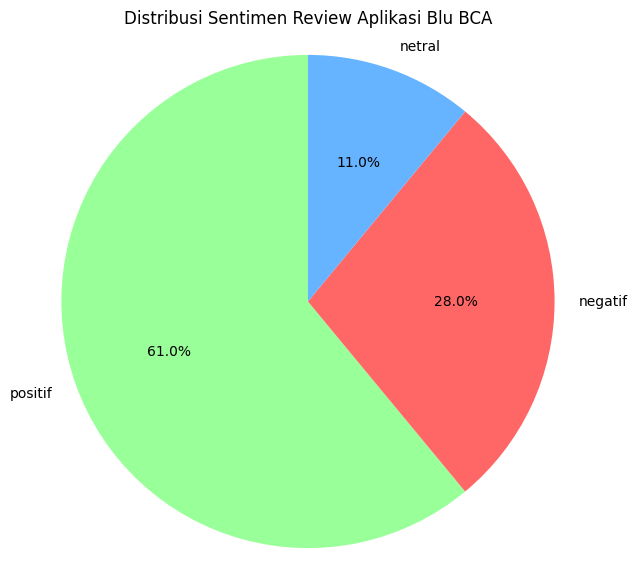

In [9]:
label_counts = df['label'].value_counts()

# Membuat pie chart
plt.figure(figsize=(7,7))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['#99ff99','#ff6666','#66b3ff'])
plt.title("Distribusi Sentimen Review Aplikasi Blu BCA")
plt.axis('equal')
plt.show()

### Data Splitting

In [10]:
# Mendefinisikan fitur (X) dan target (y)
X = df['cleaned_content']
y = df['label_encoded']

# Membagi dataset menjadi data pelatihan (train) dan data pengujian (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Tokenisasi Deep Learning

In [11]:
# Inisialisasi Tokenizer dengan parameter
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_content'])

# Konversi teks ke sequence
sequences = tokenizer.texts_to_sequences(df['cleaned_content'])
max_len = max([len(seq) for seq in sequences])  # atau tetap pakai nilai tetap seperti 100

# Padding
padded = pad_sequences(sequences, maxlen=max_len)

# Split data
from sklearn.model_selection import train_test_split
X_train_pad, X_test_pad, y_train, y_test = train_test_split(padded, df['label_encoded'], test_size=0.2, random_state=42)

### Model LSTM

In [12]:
# Model LSTM
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=max_len))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callback untuk menghentikan training saat akurasi >= 97%
class StopTrainingAtAccuracy(Callback):
    def __init__(self, target_accuracy=0.97):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get("accuracy")
        if acc is not None and acc >= self.target_accuracy:
            print(f"\n Target accuracy {self.target_accuracy * 100}% tercapai di epoch {epoch + 1}, menghentikan training...")
            self.model.stop_training = True

# Training dengan callback
stop_callback = StopTrainingAtAccuracy(target_accuracy=0.97)

history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    validation_data=(X_test_pad, y_test),
    batch_size=64,
    callbacks=[stop_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7045 - loss: 0.7123 - val_accuracy: 0.9700 - val_loss: 0.0714
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9782 - loss: 0.0579
 Target accuracy 97.0% tercapai di epoch 2, menghentikan training...
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9783 - loss: 0.0579 - val_accuracy: 0.9970 - val_loss: 0.0125


In [13]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Akurasi training: {train_acc*100:.2f}%")
print(f"Akurasi testing: {val_acc*100:.2f}%")

Akurasi training: 98.26%
Akurasi testing: 99.70%


In [14]:
# Evaluasi loss & accuracy di data testing
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\n Evaluation Result:\n- Loss     : {loss:.4f}\n- Accuracy : {accuracy * 100:.2f}%")

# Prediksi kelas dari data test
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
conf_mat = confusion_matrix(y_test, y_pred)


 Evaluation Result:
- Loss     : 0.0125
- Accuracy : 99.70%
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [15]:
# Report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:")
print(conf_mat)

Classification Report:
              precision    recall  f1-score   support

           0     0.9888    1.0000    0.9944       528
           1     1.0000    0.9725    0.9860       218
           2     1.0000    1.0000    1.0000      1254

    accuracy                         0.9970      2000
   macro avg     0.9963    0.9908    0.9935      2000
weighted avg     0.9970    0.9970    0.9970      2000

Confusion Matrix:
[[ 528    0    0]
 [   6  212    0]
 [   0    0 1254]]


## Percobaan 3 skema pelatihan yang berbeda

In [16]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf.fit_transform(df['cleaned_content'])

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)

# SVM
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Akurasi
train_acc_svm = accuracy_score(y_train, svm_model.predict(X_train))
test_acc_svm = accuracy_score(y_test, svm_model.predict(X_test))

print("SVM (TF-IDF, 80/20)")
print("Akurasi Training:", round(train_acc_svm * 100, 2), "%")
print("Akurasi Testing :", round(test_acc_svm * 100, 2), "%")

SVM (TF-IDF, 80/20)
Akurasi Training: 100.0 %
Akurasi Testing : 100.0 %


In [17]:
# Token dan Word2Vec
tokens = [nltk.word_tokenize(text) for text in df['cleaned_content']]
w2v_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1)

def avg_word2vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_w2v = np.array([avg_word2vec(t, w2v_model) for t in tokens])

# Split 80/20
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_w2v, y, test_size=0.2, stratify=y, random_state=42)

# RF
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train2, y_train2)

# Akurasi
train_acc_rf_w2v = accuracy_score(y_train2, rf_model.predict(X_train2))
test_acc_rf_w2v = accuracy_score(y_test2, rf_model.predict(X_test2))

print("Random Forest (Word2Vec, 80/20)")
print("Akurasi Training:", round(train_acc_rf_w2v * 100, 2), "%")
print("Akurasi Testing :", round(test_acc_rf_w2v * 100, 2), "%")

Random Forest (Word2Vec, 80/20)
Akurasi Training: 100.0 %
Akurasi Testing : 100.0 %


In [18]:
# TF-IDF lagi
X_tfidf2 = tfidf.fit_transform(df['cleaned_content'])

# Split 70/30
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_tfidf2, y, test_size=0.3, stratify=y, random_state=42)

# RF
rf_model2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model2.fit(X_train3, y_train3)

# Akurasi
train_acc_rf_tfidf = accuracy_score(y_train3, rf_model2.predict(X_train3))
test_acc_rf_tfidf = accuracy_score(y_test3, rf_model2.predict(X_test3))

print("Random Forest (TF-IDF, 70/30)")
print("Akurasi Training:", round(train_acc_rf_tfidf * 100, 2), "%")
print("Akurasi Testing :", round(test_acc_rf_tfidf * 100, 2), "%")

Random Forest (TF-IDF, 70/30)
Akurasi Training: 100.0 %
Akurasi Testing : 100.0 %


## Inference

In [19]:
# Review uji (positif, netral, negatif)
teks_baru = [
    "Saya sangat puas dengan aplikasi ini, sangat membantu dan tampilannya bagus!",
    "Aplikasinya biasa saja, tidak terlalu buruk tapi tidak spesial juga.",
    "Aplikasi ini jelek, banyak bug dan bikin kesel saat digunakan!"
]

tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(df['cleaned_content'])
X_new = tfidf.transform(teks_baru)

# Load model terlatih
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Prediksi
predictions = rf_model.predict(X_new)

# Mapping label
labels = ['Negatif', 'Netral', 'Positif']

# Tampilkan hasil
for review, pred in zip(teks_baru, predictions):
    print(f"Review: {review}")
    print(f"Prediksi: {labels[pred]}")
    print("-" * 50)

Review: Saya sangat puas dengan aplikasi ini, sangat membantu dan tampilannya bagus!
Prediksi: Positif
--------------------------------------------------
Review: Aplikasinya biasa saja, tidak terlalu buruk tapi tidak spesial juga.
Prediksi: Positif
--------------------------------------------------
Review: Aplikasi ini jelek, banyak bug dan bikin kesel saat digunakan!
Prediksi: Negatif
--------------------------------------------------
